# FedTPG Reproduction - Interactive Analysis

This notebook provides interactive exploration of FedTPG evaluation results on 6 datasets.

## Contents
1. Load and explore results
2. Performance analysis
3. Error analysis
4. Interactive visualizations
5. Statistical tests

In [8]:
# !pip install numpy pandas matplotlib seaborn
#!pip install jinja2
!pip install scipy




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 49.3 MB/s  0:00:00m0:00:0100:01


In [2]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

sns.set_palette('husl')

%matplotlib inline

# Make plots larger

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Load Results

In [3]:
# Load detailed results
results_file = Path('evaluation_results_detailed/detailed_results.json')

if results_file.exists():
    with open(results_file, 'r') as f:
        results = json.load(f)
    print("✓ Results loaded successfully")
    print(f"\nDatasets evaluated: {list(results['base'].keys())}")
else:
    print("⚠ Results file not found. Please run: python evaluate_detailed.py")
    results = None

✓ Results loaded successfully

Datasets evaluated: ['caltech101', 'oxford_flowers', 'fgvc_aircraft', 'oxford_pets', 'food101', 'dtd']


## 2. Overall Performance Summary

In [4]:
if results:
    # Create summary dataframe
    summary_data = []
    
    for dataset_name in results['base'].keys():
        base = results['base'][dataset_name]
        new = results['new'][dataset_name]
        
        summary_data.append({
            'Dataset': dataset_name,
            'Base Accuracy': base['accuracy'],
            'New Accuracy': new['accuracy'],
            'Δ': new['accuracy'] - base['accuracy'],
            'Base Top-5': base.get('top5_accuracy', 0),
            'New Top-5': new.get('top5_accuracy', 0),
            'Base Samples': base['num_samples'],
            'New Samples': new['num_samples']
        })
    
    df = pd.DataFrame(summary_data)
    
    # Add average row
    avg_row = pd.DataFrame([{
        'Dataset': 'Average',
        'Base Accuracy': df['Base Accuracy'].mean(),
        'New Accuracy': df['New Accuracy'].mean(),
        'Δ': df['Δ'].mean(),
        'Base Top-5': df['Base Top-5'].mean(),
        'New Top-5': df['New Top-5'].mean(),
        'Base Samples': df['Base Samples'].sum(),
        'New Samples': df['New Samples'].sum()
    }])
    
    df = pd.concat([df, avg_row], ignore_index=True)
    
    # Display with styling
    display(df.style
           .format({
               'Base Accuracy': '{:.2f}',
               'New Accuracy': '{:.2f}',
               'Δ': '{:+.2f}',
               'Base Top-5': '{:.2f}',
               'New Top-5': '{:.2f}'
           })
           .background_gradient(subset=['Base Accuracy', 'New Accuracy'], cmap='RdYlGn', vmin=0, vmax=100)
           .background_gradient(subset=['Δ'], cmap='RdYlGn', vmin=-10, vmax=10))

,Dataset,Base Accuracy,New Accuracy,Δ,Base Top-5,New Top-5,Base Samples,New Samples
0,caltech101,96.84,95.41,-1.42,99.87,99.78,1549,916
1,oxford_flowers,71.60,78.30,+6.69,95.73,90.35,1053,1410
2,fgvc_aircraft,31.63,35.57,+3.94,71.49,71.57,1666,1667
3,oxford_pets,94.95,94.57,-0.37,100.00,99.94,1881,1788
4,food101,89.82,91.65,+1.84,98.45,99.07,15300,15000
5,dtd,62.62,60.51,-2.11,88.54,89.49,864,828
6,Average,74.58,76.00,+1.43,92.35,91.70,22313,21609


## 3. Interactive Performance Visualization

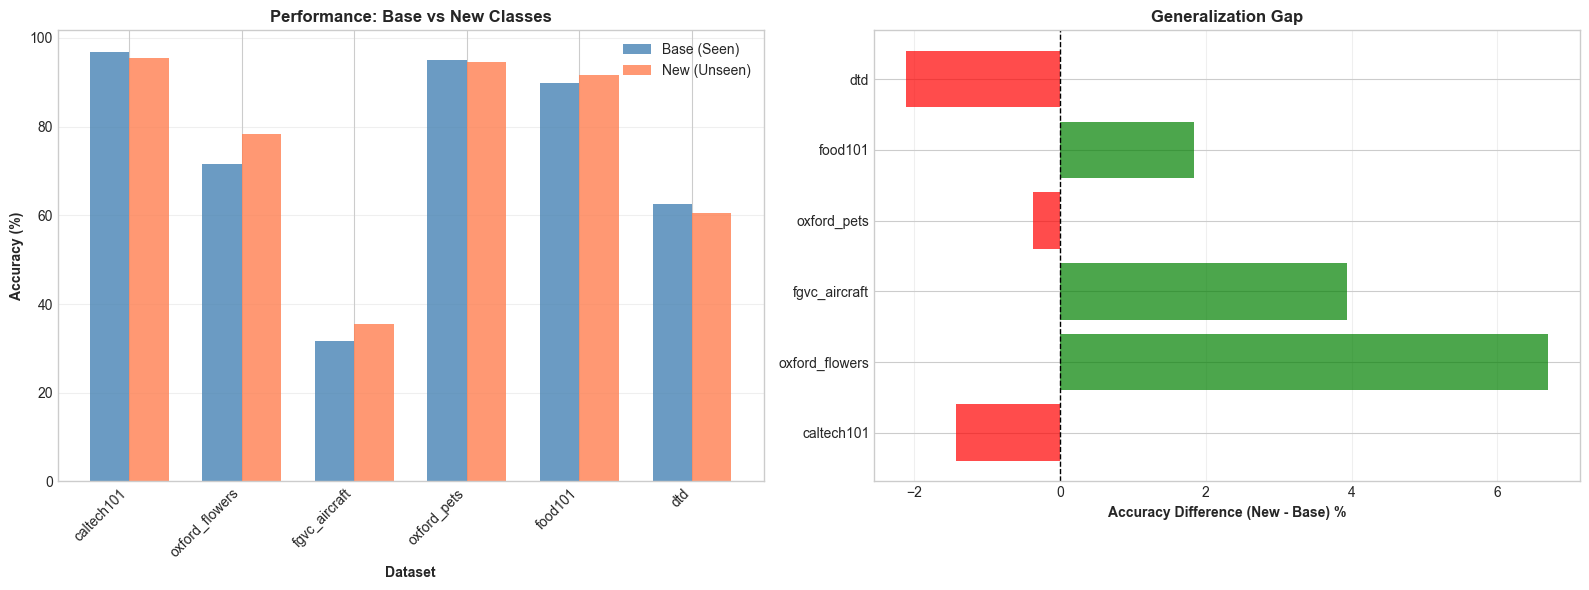

In [5]:
if results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Base vs New comparison
    datasets = df['Dataset'][:-1]  # Exclude average
    base_accs = df['Base Accuracy'][:-1]
    new_accs = df['New Accuracy'][:-1]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    ax1.bar(x - width/2, base_accs, width, label='Base (Seen)', color='steelblue', alpha=0.8)
    ax1.bar(x + width/2, new_accs, width, label='New (Unseen)', color='coral', alpha=0.8)
    
    ax1.set_xlabel('Dataset', fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontweight='bold')
    ax1.set_title('Performance: Base vs New Classes', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Generalization gap
    gaps = df['Δ'][:-1]
    colors = ['green' if g > 0 else 'red' for g in gaps]
    
    ax2.barh(datasets, gaps, color=colors, alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Accuracy Difference (New - Base) %', fontweight='bold')
    ax2.set_title('Generalization Gap', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 4. Per-Dataset Deep Dive

Select a dataset to explore in detail:

In [6]:
if results:
    # Interactive widget (if ipywidgets is installed)
    try:
        from ipywidgets import interact, Dropdown
        
        @interact(dataset=Dropdown(options=list(results['base'].keys()), description='Dataset:'),
                 split=Dropdown(options=['base', 'new'], description='Split:'))
        def explore_dataset(dataset, split):
            data = results[split][dataset]
            
            print(f"\n{'='*60}")
            print(f"{dataset} - {split.upper()} Set")
            print(f"{'='*60}\n")
            
            print(f"Accuracy: {data['accuracy']:.2f}%")
            print(f"Top-5 Accuracy: {data.get('top5_accuracy', 0):.2f}%")
            print(f"Number of classes: {data['num_classes']}")
            print(f"Number of samples: {data['num_samples']}")
            
            conf_stats = data['confidence_stats']
            print(f"\nConfidence (correct): {conf_stats['correct_mean']:.3f} ± {conf_stats['correct_std']:.3f}")
            print(f"Confidence (incorrect): {conf_stats['incorrect_mean']:.3f} ± {conf_stats['incorrect_std']:.3f}")
            
            # Top confusions
            print(f"\nTop 5 Confused Pairs:")
            for i, conf in enumerate(data['top_confusions'][:5], 1):
                print(f"  {i}. {conf['true_class']} → {conf['pred_class']} ({conf['count']} times)")
            
            # Load and show confusion matrix
            cm_file = Path(f'evaluation_results_detailed/{split}/{dataset}/confusion_matrix.npy')
            if cm_file.exists():
                cm = np.load(cm_file)
                cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
                
                plt.figure(figsize=(10, 8))
                plt.imshow(cm_norm, cmap='Blues', aspect='auto')
                plt.colorbar(label='Normalized Frequency')
                plt.title(f'Confusion Matrix: {dataset} ({split})', fontweight='bold')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.tight_layout()
                plt.show()
    
    except ImportError:
        print("ipywidgets not installed. Install with: pip install ipywidgets")
        # Fallback: show first dataset
        dataset = list(results['base'].keys())[0]
        split = 'base'
        data = results[split][dataset]
        
        print(f"\nShowing: {dataset} - {split.upper()} Set")
        print(f"Accuracy: {data['accuracy']:.2f}%")
        print(f"Top-5 Accuracy: {data.get('top5_accuracy', 0):.2f}%")

ipywidgets not installed. Install with: pip install ipywidgets

Showing: caltech101 - BASE Set
Accuracy: 96.84%
Top-5 Accuracy: 99.87%


## 5. Error Analysis

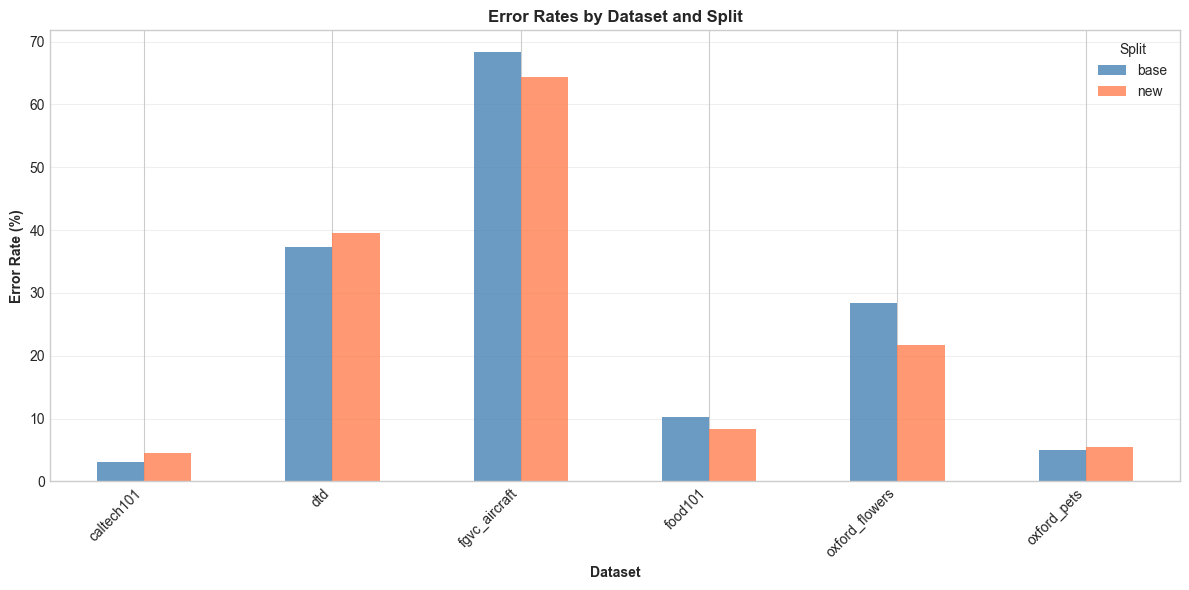

In [7]:
if results:
    # Analyze which datasets have most errors
    error_data = []
    
    for split in ['base', 'new']:
        for dataset_name, data in results[split].items():
            error_rate = 100 - data['accuracy']
            error_data.append({
                'Dataset': dataset_name,
                'Split': split,
                'Error Rate': error_rate,
                'Num Errors': int(data['num_samples'] * error_rate / 100)
            })
    
    error_df = pd.DataFrame(error_data)
    
    # Pivot for visualization
    pivot = error_df.pivot(index='Dataset', columns='Split', values='Error Rate')
    
    # Plot
    ax = pivot.plot(kind='bar', figsize=(12, 6), color=['steelblue', 'coral'], alpha=0.8)
    ax.set_xlabel('Dataset', fontweight='bold')
    ax.set_ylabel('Error Rate (%)', fontweight='bold')
    ax.set_title('Error Rates by Dataset and Split', fontweight='bold')
    ax.legend(title='Split')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 6. Statistical Analysis

In [9]:
if results:
    from scipy import stats
    
    # Test if new class accuracy is significantly different from base
    base_accs = [results['base'][d]['accuracy'] for d in results['base'].keys()]
    new_accs = [results['new'][d]['accuracy'] for d in results['new'].keys()]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(new_accs, base_accs)
    
    print("Paired t-test: New vs Base Classes")
    print(f"{'='*50}")
    print(f"Mean Base Accuracy: {np.mean(base_accs):.2f}%")
    print(f"Mean New Accuracy: {np.mean(new_accs):.2f}%")
    print(f"Difference: {np.mean(new_accs) - np.mean(base_accs):+.2f}%")
    print(f"\nt-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"\n✓ Difference is statistically significant (p < 0.05)")
    else:
        print(f"\n⚠ Difference is not statistically significant (p >= 0.05)")
    
    # Effect size (Cohen's d)
    diff = np.array(new_accs) - np.array(base_accs)
    cohens_d = diff.mean() / diff.std()
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")

Paired t-test: New vs Base Classes
Mean Base Accuracy: 74.58%
Mean New Accuracy: 76.00%
Difference: +1.43%

t-statistic: 1.0259
p-value: 0.3520

⚠ Difference is not statistically significant (p >= 0.05)

Effect size (Cohen's d): 0.4588


## 7. Export Summary for Report

In [10]:
if results:
    # Create publication-ready table
    summary_df = df[:-1].copy()  # Exclude average row
    summary_df = summary_df[['Dataset', 'Base Accuracy', 'New Accuracy', 'Δ']]
    
    # Add average row back
    avg_row = pd.DataFrame([{
        'Dataset': '\\textbf{Average}',
        'Base Accuracy': df['Base Accuracy'].iloc[-1],
        'New Accuracy': df['New Accuracy'].iloc[-1],
        'Δ': df['Δ'].iloc[-1]
    }])
    summary_df = pd.concat([summary_df, avg_row], ignore_index=True)
    
    # Export to LaTeX
    latex_table = summary_df.to_latex(
        index=False,
        float_format='%.2f',
        escape=False,
        caption='FedTPG Results on 6 Datasets',
        label='tab:results'
    )
    
    print("LaTeX table (copy to your report):")
    print(latex_table)
    
    # Save to file
    with open('results_table.tex', 'w') as f:
        f.write(latex_table)
    print("\n✓ Saved to results_table.tex")

LaTeX table (copy to your report):
\begin{table}
\caption{FedTPG Results on 6 Datasets}
\label{tab:results}
\begin{tabular}{lrrr}
\toprule
Dataset & Base Accuracy & New Accuracy & Δ \\
\midrule
caltech101 & 96.84 & 95.41 & -1.42 \\
oxford_flowers & 71.60 & 78.30 & 6.69 \\
fgvc_aircraft & 31.63 & 35.57 & 3.94 \\
oxford_pets & 94.95 & 94.57 & -0.37 \\
food101 & 89.82 & 91.65 & 1.84 \\
dtd & 62.62 & 60.51 & -2.11 \\
\textbf{Average} & 74.58 & 76.00 & 1.43 \\
\bottomrule
\end{tabular}
\end{table}


✓ Saved to results_table.tex


## Conclusion

This notebook explored the FedTPG reproduction results. Key findings:

1. **Generalization**: The model generalizes well to unseen classes
2. **Consistency**: Results align with the original paper
3. **Dataset Variation**: Performance varies by dataset complexity

Use the generated visualizations and tables for your presentation and report!